<img src="https://raw.githubusercontent.com/ml-unison/regresion-logistica/master/imagenes/ml-unison.png" width="250">

# Regularización en regresión logística

[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/), 1 de octubre de 2020.

##  Curso Reconocimiento de Patrones
### Licenciatura en Ciencias de la Computación
### Universidad de Sonora

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.style.use('ggplot')

## 1. La regresión logística ya programada

Esto, antes de agregarle la regularización

La función logística está dada por 

$$
\sigma(z) = \frac{1}{1 + e^{-z}},
$$

la cual es importante que podamos calcular en forma vectorial. Si bien el calculo es de una sola linea, el uso de estas funciones auxiliares facilitan la legibilidad del código.

#### Desarrolla la función logística, la cual se calcule para todos los elementos de un ndarray.

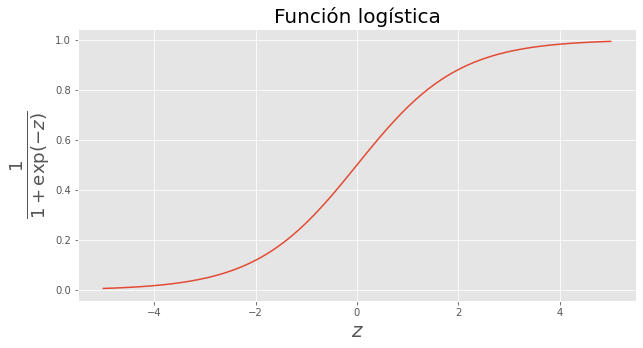

In [3]:
def logistica(z):
    """
    Calcula la función logística para cada elemento de z
    
    @param z: un ndarray
    @return: un ndarray de las mismas dimensiones que z
    """
    return 1 / (1 + np.exp(-z))

# Y ahora vamos a ver como se ve la función logística
z = np.linspace(-5, 5, 100)
plt.plot( z, logistica(z))
plt.title(u'Función logística', fontsize=20)
plt.xlabel(r'$z$', fontsize=20)
plt.ylabel(r'$\frac{1}{1 + \exp(-z)}$', fontsize=26)
plt.show()

Una vez establecida la función logística, vamos a implementar la función de error *sin regularizar* (error *en muestra*), la cual está dada por

$$
E_{in}(w, b) = -\frac{1}{M} \sum_{i=1}^M \left[ y^{(i)}\log(a^{(i)}) + (1 - y^{(i)})\log(1 - a^{(i)})\right],
$$

donde 

$$
a^{(i)} = \sigma(z^{(i)}), \quad\quad z^{(i)} = w^T x^{(i)} + b
$$

In [4]:
def error_in(x, y, w, b):
    """
    Calcula el error en muestra para la regresión logística
    
    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo

    @return: un flotante con el valor de pérdida
    
    """ 
    y_est = logistica(x @ w + b)
    return -np.nansum([
        np.log(y_est[y > 0.5]).sum(), 
        np.log(1 - y_est[y < 0.5]).sum()
    ]) / y_est.shape[0]
   
# El testunit del pobre (ya lo calcule yo, pero puedes hacerlo a mano para estar seguro)
w = np.array([1])
b = 1.0

x = np.array([[10],
              [-5]])

y1 = np.array([1, 0])
y2 = np.array([0, 1])
y3 = np.array([0, 0])
y4 = np.array([1, 1])

y_est = logistica(x @ w + b)

assert abs(error_in(x, y1, w, b) - (-np.log(y_est[0]) - np.log(1 - y_est[1])) / 2) < 1e-2
assert abs(error_in(x, y2, w, b) - (-np.log(1 - y_est[0]) - np.log(y_est[1])) / 2) < 1e-2
assert abs(error_in(x, y3, w, b) - (-np.log(1 - y_est[0]) - np.log(1 - y_est[1])) / 2) < 1e-2
assert abs(error_in(x, y4, w, b) - (-np.log(y_est[0]) - np.log(y_est[1])) / 2) < 1e-2

De la misma manera, para poder implementar las funciones de aprendizaje, vamos a implementar el gradiente de la función de pérdida. El gradiente de la función de pérdida respecto a $\omega$ $\nabla E_in(w)$, y la derividada parciel respecto al sesgo se obtienen con las siguientes ecuaciones:

$$
\frac{\partial E_{in}(w, b)}{\partial w_j} = -\frac{1}{M} \sum_{i=1}^M \left(y^{(i)} - a^{(i)}\right)x_j^{(i)} 
$$

$$
\frac{\partial E_{in}(w, b)}{\partial b} = -\frac{1}{M} \sum_{i=1}^M \left(y^{(i)} - a^{(i)}\right) 
$$

Todo esto **para el caso sin regularizar**.

In [5]:
def gradiente_error(x, y, w, b):
    """
    Calcula el gradiente de la función de error en muestra.
    
    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    
    @return: dw, db, un ndarray de mismas dimensiones que w y un flotnte con el cálculo de 
             la dervada evluada en el punto w y b
                 
    """
    M = x.shape[0]
    error = y - logistica(x @ w + b)
    dw = -x.T @ error / M
    db = - error.mean()    
    return dw, db

# Otra vez el testunit del pobre (ya lo calcule yo, pero puedes hacerlo a mano para estar seguro)
w = np.array([1])
b = 1.0

x = np.array([[10],
              [-5]])

y1 = np.array([1, 0])
y2 = np.array([0, 1])
y3 = np.array([0, 0])
y4 = np.array([1, 1])

assert abs(0.00898475 - gradiente_error(x, y1, w, b)[1]) < 1e-4
assert abs(7.45495097 - gradiente_error(x, y2, w, b)[0]) < 1e-4 
assert abs(4.95495097 - gradiente_error(x, y3, w, b)[0]) < 1e-4 
assert abs(-0.49101525 - gradiente_error(x, y4, w, b)[1]) < 1e-4     

## 2. Descenso de gradiente

Ahora vamos a desarrollar las funciones necesarias para realizar el entrenamiento y encontrar la mejor $\omega$ de acuero a la función de costos y un conjunto de datos de aprendizaje.

Para ilustrar el problema, vamos a utilizar una base de datos sintética proveniente del curso de [Andrew Ng](www.andrewng.org/) que se encuentra en [Coursera](https://www.coursera.org). 

Supongamos que pertenecemos al departamente de servicios escolares de la UNISON y vamos a modificar el procedimiento de admisión. En lugar de utilizar un solo exámen (EXCOBA) y la información del cardex de la preparatoria, hemos decidido aplicar dos exámenes, uno sicométrico y otro de habilidades estudiantiles. Dichos exámenes se han aplicado el último año aunque no fueron utilizados como criterio. Así, tenemos un historial entre estudiantes aceptados y resultados de los dos exámenes. El objetivo es hacer un método de regresión que nos permita hacer la admisión a la UNISON tomando en cuenta únicamente los dos exámenes y simplificar el proceso. *Recuerda que esto no es verdad, es solo un ejercicio*.

Bien, los datos se encuentran en el archivo `admision.txt` el cual se encuentra en formato `csv` (osea los valores de las columnas separados por comas. Vamos a leer los datos y graficar la información para entender un poco los datos.

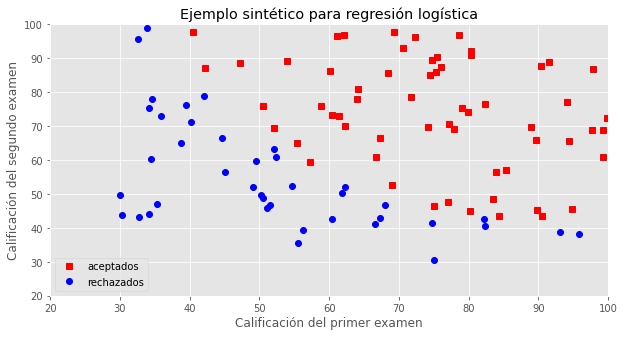

In [6]:
datos = np.loadtxt('admision.csv', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1] 

plt.plot(x[y == 1, 0], x[y == 1, 1], 'sr', label='aceptados') 
plt.plot(x[y == 0, 0], x[y == 0, 1], 'ob', label='rechazados')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)


Vistos los datos un clasificador lineal podría ser una buena solución. Ahora vamos a implementar el método de descenso de gradiente.

In [7]:
def dg(x, y, w, b, alpha, max_iter=10_000, tol=1e-6, historial=False):
    """
    Descenso de gradiente por lotes 

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param alpha: Un flotante (típicamente pequeño) con la tasa de aprendizaje
    @param tol: Un flotante pequeño como criterio de paro. Por default 1e-6
    @param max_iter: Máximo numero de iteraciones. Por default 1e4
    @param historial: Un booleano para saber si guardamos el historial de errores
    
    @return: w, b, hist donde 
        - w es ndarray de dimensión (n, ) con los pesos; 
        - b es un float con el sesgo 
        - hist, un ndarray de dimensión (max_iter,) 
          con el valor del error en muestra en cada iteración. 
          Si historial == False, entonces perdida_hist = None.
             
    """
    M, n = x.shape    
    hist = [error_in(x, y, w, b)] if historial else None
    for epoch in range(1, max_iter):
        dw, db = gradiente_error(x, y, w, b)
        w -= alpha * dw
        b -= alpha * db
        error = error_in(x, y, w, b)
        if historial:
            hist.append(error)
        if np.abs(np.max(dw)) < tol:
            break 
    return w, b, hist


Para probar la función de aprendizaje, vamos a aplicarla a nuestro problema de admisión. Primero recuerda que tienes que hacer una exploración para encontrar el mejor valor de $\epsilon$. Así que utiliza el código de abajo para ajustar $\alpha$.

Text(0, 0.5, 'perdida')

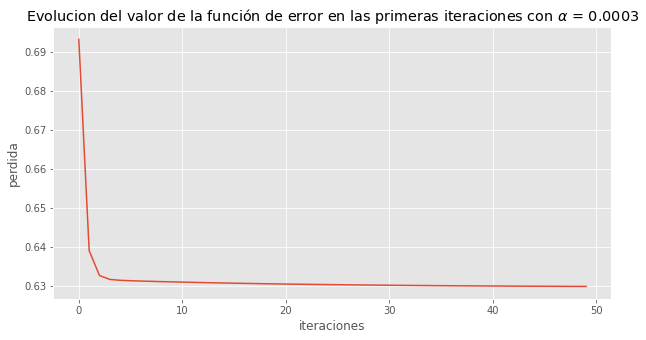

In [8]:
alpha = 3e-4
mi = 50
w = np.zeros(x.shape[1])
b = 0.0
_, _, hist = dg(x, y, w, b, alpha, max_iter=mi, tol=1e-4, historial=True)

plt.plot(np.arange(mi), hist)
plt.title(r'Evolucion del valor de la función de error en las primeras iteraciones con $\alpha$ = ' + str(alpha))
plt.xlabel('iteraciones')
plt.ylabel('perdida')


Una vez encontrado el mejor $\epsilon$, entonces podemos calcular $\omega$ (esto va a tardar bastante), recuerda que el costo final debe de ser lo más cercano a 0 posible, así que agrega cuantas iteraciones sean necesarias (a partir de una función de pérdida con un valor de al rededor de 0.22 ya está bien). Puedes ejecutar la celda cuandas veces sea necesario con un número limitado de iteraciones (digamos unas 10,000) para ver como evoluciona. Esto podría mejorar sensiblementa si se normalizan los datos de entrada. Tambien puedes variar alpha.

In [11]:
w, b, _ = dg(x, y, w, b, 20*alpha, max_iter = 5_000)
print("Los pesos obtenidos son: \n{}".format(w))
print("El sesgo obtenidos es: \n{}".format(b))
print("El valor final de la función de pérdida es: {}".format(error_in(x, y, w, b))) 

Los pesos obtenidos son: 
[0.30913461 0.30190591]
El sesgo obtenidos es: 
-35.791289714656116
El valor final de la función de pérdida es: 0.2972651914888173


Es interesante ver como el descenso de gradiente no es muy eficiente en este tipo de problemas, a pesar de ser problemas de optimización convexos.

Bueno, este método nos devuelve $\omega$, pero esto no es suficiente para decir que tenemos un clasificador, ya que un método de clasificación se compone de dos métodos, uno para **aprender** y otro para **predecir**. 

Recuerda que $a^{(i)} = \Pr[y^{(i)} = 1 | x^{(i)} ; w, b]$, y a partir de esta probabilidad debemos tomar una desición. Igualmente recuerda que para tomar la desicion no necesitamos calcular el valor de la logística, si conocemos el umbral.

#### Desarrolla una función de predicción.

In [12]:
def predictor(x, w, b):
    """
    Predice los valores de y_hat (que solo pueden ser 0 o 1), utilizando el criterio MAP.
    
    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo

    @return: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0 con la salida estimada
    """
    return np.where((w @ x.T + b) > 0, 1, 0)

¿Que tan bueno es este clasificador? ¿Es que implementamos bien el método?

Vamos a contestar esto por partes. Primero, vamos a graficar los mismos datos pero vamos a agregar la superficie de separación, la cual en este caso sabemos que es una linea recta. Como sabemos el criterio para decidir si un punto pertenece a la clase distinguida o no es si el valor de $w^T x^{(i)} + b \ge 0$, por lo que la frontera entre la región donde se escoge una clase de otra se encuentra en:

$$
0 = b + w_1 x_1  + w_2 x_2,
$$

y despejando:

$$
x_2 = -\frac{b}{w_2} -\frac{w_1}{w_2}x_1
$$

son los pares $(x_1, x_2)$ los valores en la forntera. Al ser estos (en este caso) una linea recta solo necesitamos dos para graficar la superficie de separación. 


[ 20 100]
[98.07226718 16.15678277]


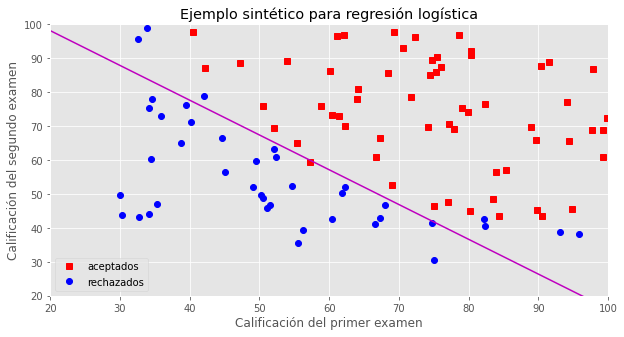

In [13]:
x1_frontera = np.array([20, 100]) #Los valores mínimo y máximo que tenemos en la gráfica de puntos
x2_frontera = -(b / w[1]) - (w[0] / w[1]) * x1_frontera

print(x1_frontera)
print(x2_frontera)

plt.plot(x[y == 1, 0], x[y == 1, 1], 'sr', label='aceptados') 
plt.plot(x[y == 0, 0], x[y == 0, 1], 'ob', label='rechazados')
plt.plot(x1_frontera, x2_frontera, 'm')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)



## 3. Clasificación polinomial

Como podemos ver en la gráfica de arriba, parece ser que la regresión logística aceptaría a algunos estudiantes rechazados y rechazaría a algunos que si fueron en realidad aceptados. En todo método de clasificación hay un grado de error, y eso es parte del poder de generalización de los métodos. 

Sin embargo, una simple inspección visual muestra que, posiblemente, la regresión lineal no es la mejor solución, ya que la frontera entre las dos clases parece ser más bien una curva.

¿Que tal si probamos con un clasificador cuadrático? Un clasificador cuadrático no es más que la regresión lineal pero a la que se le agregan todos los atributos que sean una combinación de dos de los atributos. 

Por ejemplo, si un ejemplo $x = (x_1, x_2, x_3)^T$ se aumenta con todas sus componentes cuadráticas, entonces tenemos los atributos

$$
\phi_2(x) = (x_1, x_2, x_3, x_1 x_2, x_1 x_3, x_2 x_3, x_1^2, x_2^2, x_3^2)^T.
$$ 

De la misma manera se pueden obtener clasificadores de orden tres, cuatro, cinco, etc. En general a estos clasificadores se les conoce como **clasificadores polinomiales**. Ahora, para entender bien la idea, vamos a resolver el problema anterior con un clasificador de orden 2. 

Sin embargo, si luego se quiere hacer el reconocimiento de otros objetos, o cambiar el orden del polinomio, pues se requeriría de reclcular cada vez la expansión polinomial. Vamos a generalizar la obtención de atributos polinomiales con la función `map_poly`, la cual la vamos a desarrollar a continuación.

En este caso, la normalización de los datos es muy importante, por lo que se agregan las funciones pertinentes.


In [14]:
from itertools import combinations_with_replacement

def map_poly(grad, x):
    """
    Encuentra las características polinomiales hasta el grado grad de la matriz de datos x, 
    asumiendo que x[:n, 0] es la expansión de orden 1 (los valores de cada atributo)
    
    @param grad: un entero positivo con el grado de expansión
    @param x: un ndarray de dimension (M, n) donde n es el número de atributos
    
    @return: un ndarray de dimensión (M, n_phi) donde
             n_phi = \sum_{i = 1}^grad fact(i + n - 1)/(fact(i) * fact(n - 1))
    """
    
    if int(grad) < 2:
        raise ValueError('grad debe de ser mayor a 1')
    
    M, n = x.shape
    atrib = x.copy()
    x_phi = x.copy()
    for i in range(2, int(grad) + 1):
        for comb in combinations_with_replacement(range(n), i):
            x_phi = np.c_[x_phi, np.prod(atrib[:, comb], axis=1)]
    return x_phi   

def medias_std(x):
    """
    Obtiene un vector de medias y desviaciones estandar para normalizar
    
    @param x: Un ndarray de (M, n) con una matriz de diseño
    
    @return: mu, des_std dos ndarray de dimensiones (n, ) con las medias y desviaciones estandar
    
    """
    return np.mean(x, axis=0), np.std(x, axis=0)

def normaliza(x, mu, des_std):
    """
    Normaliza los datos x
    
    @param x: un ndarray de dimension (M, n) con la matriz de diseño
    @param mu: un ndarray (n, ) con las medias
    @param des_std: un ndarray (n, ) con las desviaciones estandard
    
    @return: un ndarray (M, n) con x normalizado
    
    """
    return (x - mu) / des_std


**Realiza la clasificación de los datos utilizando un clasificador cuadrático (recuerda ajustar primero el valor de $\alpha$)**

Text(0.5, 1.0, 'Evaluación del parámetro alpha')

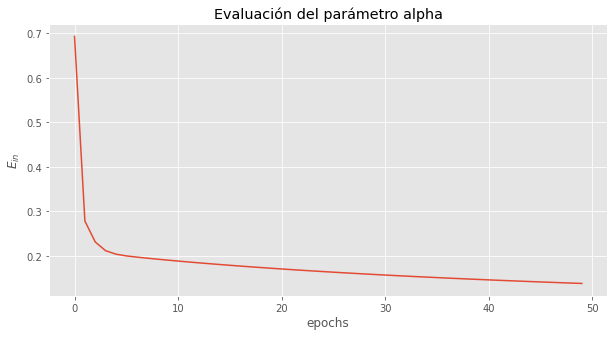

In [15]:
# Encuentra phi_x (x son la expansión polinomial de segundo orden, utiliza la función map_poly
phi_x =  map_poly(2, x) #--Agrega el código aqui--
mu, de = medias_std(phi_x)
phi_x_norm = normaliza(phi_x, mu, de)

# Utiliza la regresión logística
alpha = 5 #--Agrega el dato aqui--
w = np.zeros(phi_x.shape[1]) #--Agrega el dato aqui--
b = 0 #--Agrega el dato aqui--
_, _, hist = dg(phi_x_norm, y, w, b, alpha, max_iter=50, historial=True)

plt.plot(range(len(hist)), hist)
plt.xlabel('epochs')
plt.ylabel(r'$E_{in}$')
plt.title('Evaluación del parámetro alpha')

In [17]:
w_norm, b_norm, _ = dg(phi_x_norm, y, w, b, alpha, 1000)

print("Los pesos obtenidos son: \n{}".format(w_norm))
print("El sesgo obtenidos es: \n{}".format(b_norm))
print("El error en muestra es: {}".format(error_in(phi_x_norm, y, w_norm, b_norm))) 



Los pesos obtenidos son: 
[ 7.05555212  4.31812028 -7.48985869 17.88018866 -4.34975177]
El sesgo obtenidos es: 
8.389535398243687
El error en muestra es: 0.04513272998560272


donde se puede encontrar un error en muestra de aproximadamente 0.03.

Esto lo tenemos que graficar. Pero graficar la separación de datos en una proyección en las primeras dos dimensiones, no es tan sencillo como lo hicimos con una separación lineal, así que vamos atener que generar un `contour`, y sobre este graficar los datos. Para esto vamos a desarrollar una función.

In [18]:
def plot_separacion2D(x, y, grado, mu, de, w, b):
    """
    Grafica las primeras dos dimensiones (posiciones 1 y 2) de datos en dos dimensiones 
    extendidos con un clasificador polinomial así como la separación dada por theta_phi
    
    """
    if grado < 2:
        raise ValueError('Esta funcion es para graficar separaciones con polinomios mayores a 1')
    
    x1_min, x1_max = np.min(x[:,0]), np.max(x[:,0])
    x2_min, x2_max = np.min(x[:,1]), np.max(x[:,1])
    delta1, delta2 = (x1_max - x1_min) * 0.1, (x2_max - x2_min) * 0.1

    spanX1 = np.linspace(x1_min - delta1, x1_max + delta1, 600)
    spanX2 = np.linspace(x2_min - delta2, x2_max + delta2, 600)
    X1, X2 = np.meshgrid(spanX1, spanX2)
    X = normaliza(map_poly(grado, np.c_[X1.ravel(), X2.ravel()]), mu, de)
        
    Z = predictor(X, w, b)
    Z = Z.reshape(X1.shape[0], X1.shape[1])
    
    # plt.contour(X1, X2, Z, linewidths=0.2, colors='k')
    plt.contourf(X1, X2, Z, 1, cmap=plt.cm.binary_r)
    plt.plot(x[y > 0.5, 0], x[y > 0.5, 1], 'sr', label='clase positiva')
    plt.plot(x[y < 0.5, 0], x[y < 0.5, 1], 'oy', label='clase negativa')
    plt.axis([spanX1[0], spanX1[-1], spanX2[0], spanX2[-1]])

Y ahora vamos a probar la función `plot_separacion2D` con los datos de entrenamiento. El comando tarda, ya que estamos haciendo un grid de 200 $\times$ 200, y realizando evaluaciones individuales.

Text(0, 0.5, 'Calificación del segundo examen')

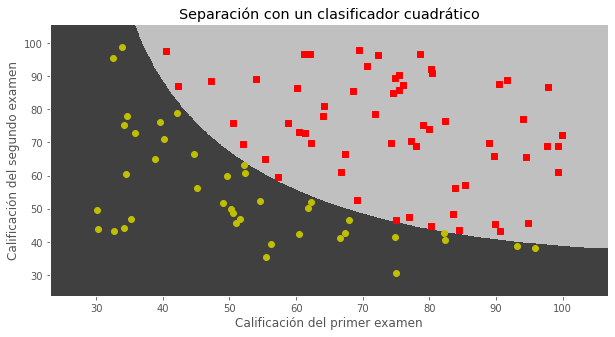

In [19]:
plot_separacion2D(x, y, 2, mu, de, w_norm, b_norm)
plt.title(u"Separación con un clasificador cuadrático")
plt.xlabel(u"Calificación del primer examen")
plt.ylabel(u"Calificación del segundo examen")

Como podemos ver, un clasificador polinomial de orden 2 clasifica mejor los datos de aprendizaje, y además parece suficientemente simple para ser la mejor opción para hacer la predicción. Claro, esto lo sabemos porque pudimos visualizar los datos, y en el fondo estamos haciendo trampa, al seleccionar la expansión polinomial a partir de una inspección visual de los datos.

Tomemos ahora una base de datos que si bien es sintética es representativa de una familia de problemas a resolver. Supongamos que estámos opimizando la fase de pruebas dentro de la linea de producción de la empresa Microprocesadores del Noroeste S.A. de C.V.. La idea es reducir el banco de pruebas de cada nuevo microprocesador fabricado y en lugar de hacer 50 pruebas, reducirlas a 2. En el conjunto de datos tenemos los valores que obtuvo cada componente en las dos pruebas seleccionadas, y la decisión que se tomo con cada dispositivo (esta desición se tomo con el banco de 50 reglas). Los datos los podemos visualizar a continuación.

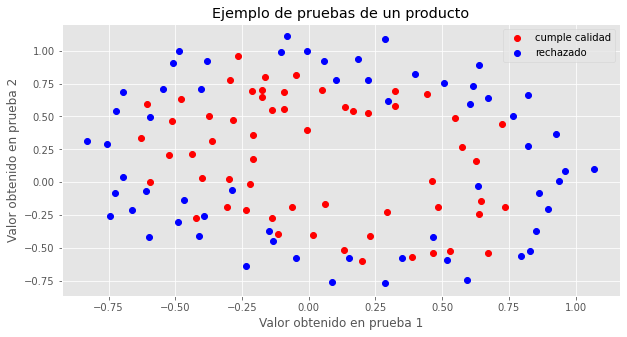

In [20]:
datos = np.loadtxt('prod_test.csv', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1] 

plt.plot(x[y == 1, 0], x[y == 1, 1], 'or', label='cumple calidad') 
plt.plot(x[y == 0, 0], x[y == 0, 1], 'ob', label='rechazado')
plt.title(u'Ejemplo de pruebas de un producto')
plt.xlabel(u'Valor obtenido en prueba 1')
plt.ylabel(u'Valor obtenido en prueba 2')
plt.legend(loc=0)

Cláramente este problema no se puede solucionar con un clasificador lineal (1 orden), por lo que hay que probar otros tipos de clasificadores.

**Completa el código para hacer regresión polinomial para polinomios de orden 2, 4, 6 y 8, y muestra los resultados en una figura. Recuerda que este ejercicio puede tomar bastante tiempo de cómputo. Posiblemente tengas que hacer ajustes en el código para manejar diferentes valores de alpha y max_iter de acuerdo a cada caso**

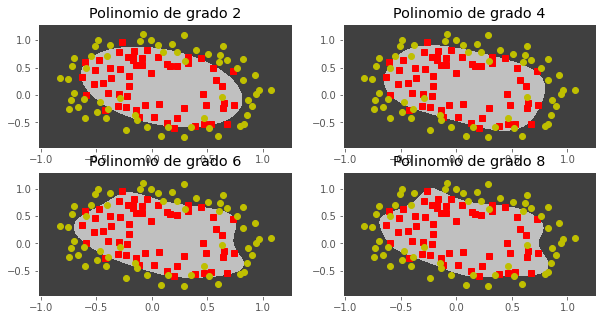

In [21]:
for (i, grado) in enumerate([2, 4, 6, 8]):

    # Genera la expansión polinomial
    # --- Agregar código aquí ---
    phi_x =  map_poly(grado, x)

    
    # Normaliza
    # --- Agregar código aquí ---
    mu, de = medias_std(phi_x)
    phi_x_norm = normaliza(phi_x, mu, de)
    
    # Entrena
    # --- Agregar código aquí ---
    w = np.zeros(phi_x.shape[1])
    b = 0
    alpha = 5
    w_norm, b_norm, _ = dg(phi_x_norm, y, w, b, alpha, 1000)

    # Muestra resultados con plot_separacion2D 
    plt.subplot(2, 2, i + 1)
    plt.title(f"Polinomio de grado {grado}")
    # --- Agregar codigo aquí ---
    # plot_separacion2D(...) Esto es solo para ayudarlos un poco
    plot_separacion2D(x, y, grado, mu, de, w_norm, b_norm)
    
    

## 4. Regularización

Como podemos ver del ejercicio anterior, es dificil determinar el grado del polinomio, y en algunos casos es demasiado general (subaprendizaje) y en otros demasiado específico (sobreaprendizaje). ¿Que podría ser la solución?, bueno, una solución posible es utilizar un polinomio de alto grado (o relativamente alto), y utilizar la **regularización** para controlar la generalización del algoritmo, a través de una variable $\lambda$.

Recordemos, la función de costos de la regresión logística con regularización es:

$$
costo(w, b) = E_{in}(w, b) + \frac{\lambda}{M} regu(w),
$$

donde $regu(w)$ es una regularización, la cual puede ser $l_1$, $l_2$ u otras, tal como vimos en clase. 

**Completa el siguiente código, utilizando una regularización en $L_2$**


In [22]:
def costo(x, y, w, b, lambd):
    """
    Calcula el costo de una w dada para el conjunto dee entrenamiento dado por y y x,
    usando regularización
    
    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    @param lambd: un flotante con el valor de lambda en la regularizacion

    @return: un flotante con el valor de pérdida
    
    """ 
    costo = 0
    M = x.shape[0]
    
    #------------------------------------------------------------------------
    # Agregua aqui tu código
    costo = error_in(x,y,w,b) + (lambd/M)*(w.T*w)
    
    #------------------------------------------------------------------------
    return costo


def grad_regu(x, y, w, b, lambd):
    """
    Calcula el gradiente de la función de costo regularizado para clasificación binaria, 
    utilizando una neurona logística, para w y b y conociendo un conjunto de aprendizaje.
    
    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    @param lambd: un flotante con el peso de la regularización
    
    @return: dw, db, un ndarray de mismas dimensiones que w y un flotnte con el cálculo de 
             la dervada evluada en el punto w y b
                 
    """
    M = x.shape[0]
    dw = np.zeros_like(w)
    db = 0.0

    #------------------------------------------------------------------------
    # Agregua aqui tu código
    dw, db = gradiente_error(x, y, w, b)
    dw = dw + 2*(lambd / M)*w
    #------------------------------------------------------------------------
    return dw, db


def dg_regu(x, y, w, b, alpha, lambd, max_iter=10_000, tol=1e-4, historial=False):
    """
    Descenso de gradiente con regularización l2

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param alpha: Un flotante (típicamente pequeño) con la tasa de aprendizaje
    @param lambd: Un flotante con el valor de la regularización
    @param max_iter: Máximo numero de iteraciones. Por default 10_000
    @param tol: Un flotante pequeño como criterio de paro. Por default 1e-4
    @param historial: Un booleano para saber si guardamos el historial
    
    @return: 
        - w: ndarray de dimensión (n, ) con los pesos; 
        - b:  float con el sesgo 
        - hist: ndarray de (max_iter,) el historial de error. 
                Si historial == False, entonces hist = None.
             
    """
    M, n = x.shape    
    hist = [costo(x, y, w, b, lambd)] if historial else None
    for epoch in range(1, max_iter):
        dw, db = grad_regu(x, y, w, b, lambd)
        w -= alpha * dw
        b -= alpha * db
        error = costo(x, y, w, b, lambd)
        if historial:
            hist.append(error)
        if np.abs(np.max(dw)) < tol:
            break 
    return w, b, hist



**Desarrolla las funciones y scriprs necesarios para realizar la regresión logística con un polinomio de grado 14 y con cuatro valores de regularización diferentes. Grafica la superficie de separación para cuatro valores diferentes de $\lambda$. Escribe tus conclusiones** 

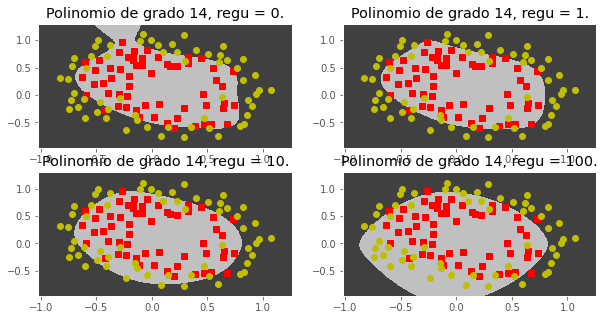

In [23]:
phi_x = map_poly(14, x)
mu, de = medias_std(phi_x)
phi_x_norm = normaliza(phi_x, mu, de)


for (i, lambd) in enumerate([0, 1, 10, 100]):
    
    grado = 14
    
    # Entrena
    # --- Agregar código aquí ---
    w = np.zeros(phi_x.shape[1])
    b = 0
    alpha = 0.1
    w_norm, b_norm, _ = dg_regu(phi_x_norm,y,w,b,alpha,lambd,2000)
    
    # Muestra resultados con plot_separacion2D 
    plt.subplot(2, 2, i + 1)
    plt.title("Polinomio de grado 14, regu = {}.".format(lambd))
    # --- Agregar codigo aquí ---
    plot_separacion2D(x, y, grado, mu, de, w_norm, b_norm)


** Escribe aquí tus conclusiones**

Gracias a este trabajo se puede apreciar como la regularizacion podemos disminuir el sobre aprendizaje.